# Aplicación de recomendadión de películas. 
### La recomendación se basa en calcular embedings vectoriales de las overviews y el título de las películas sugeridas por el usuario y compararlos con las películas de la base de datos


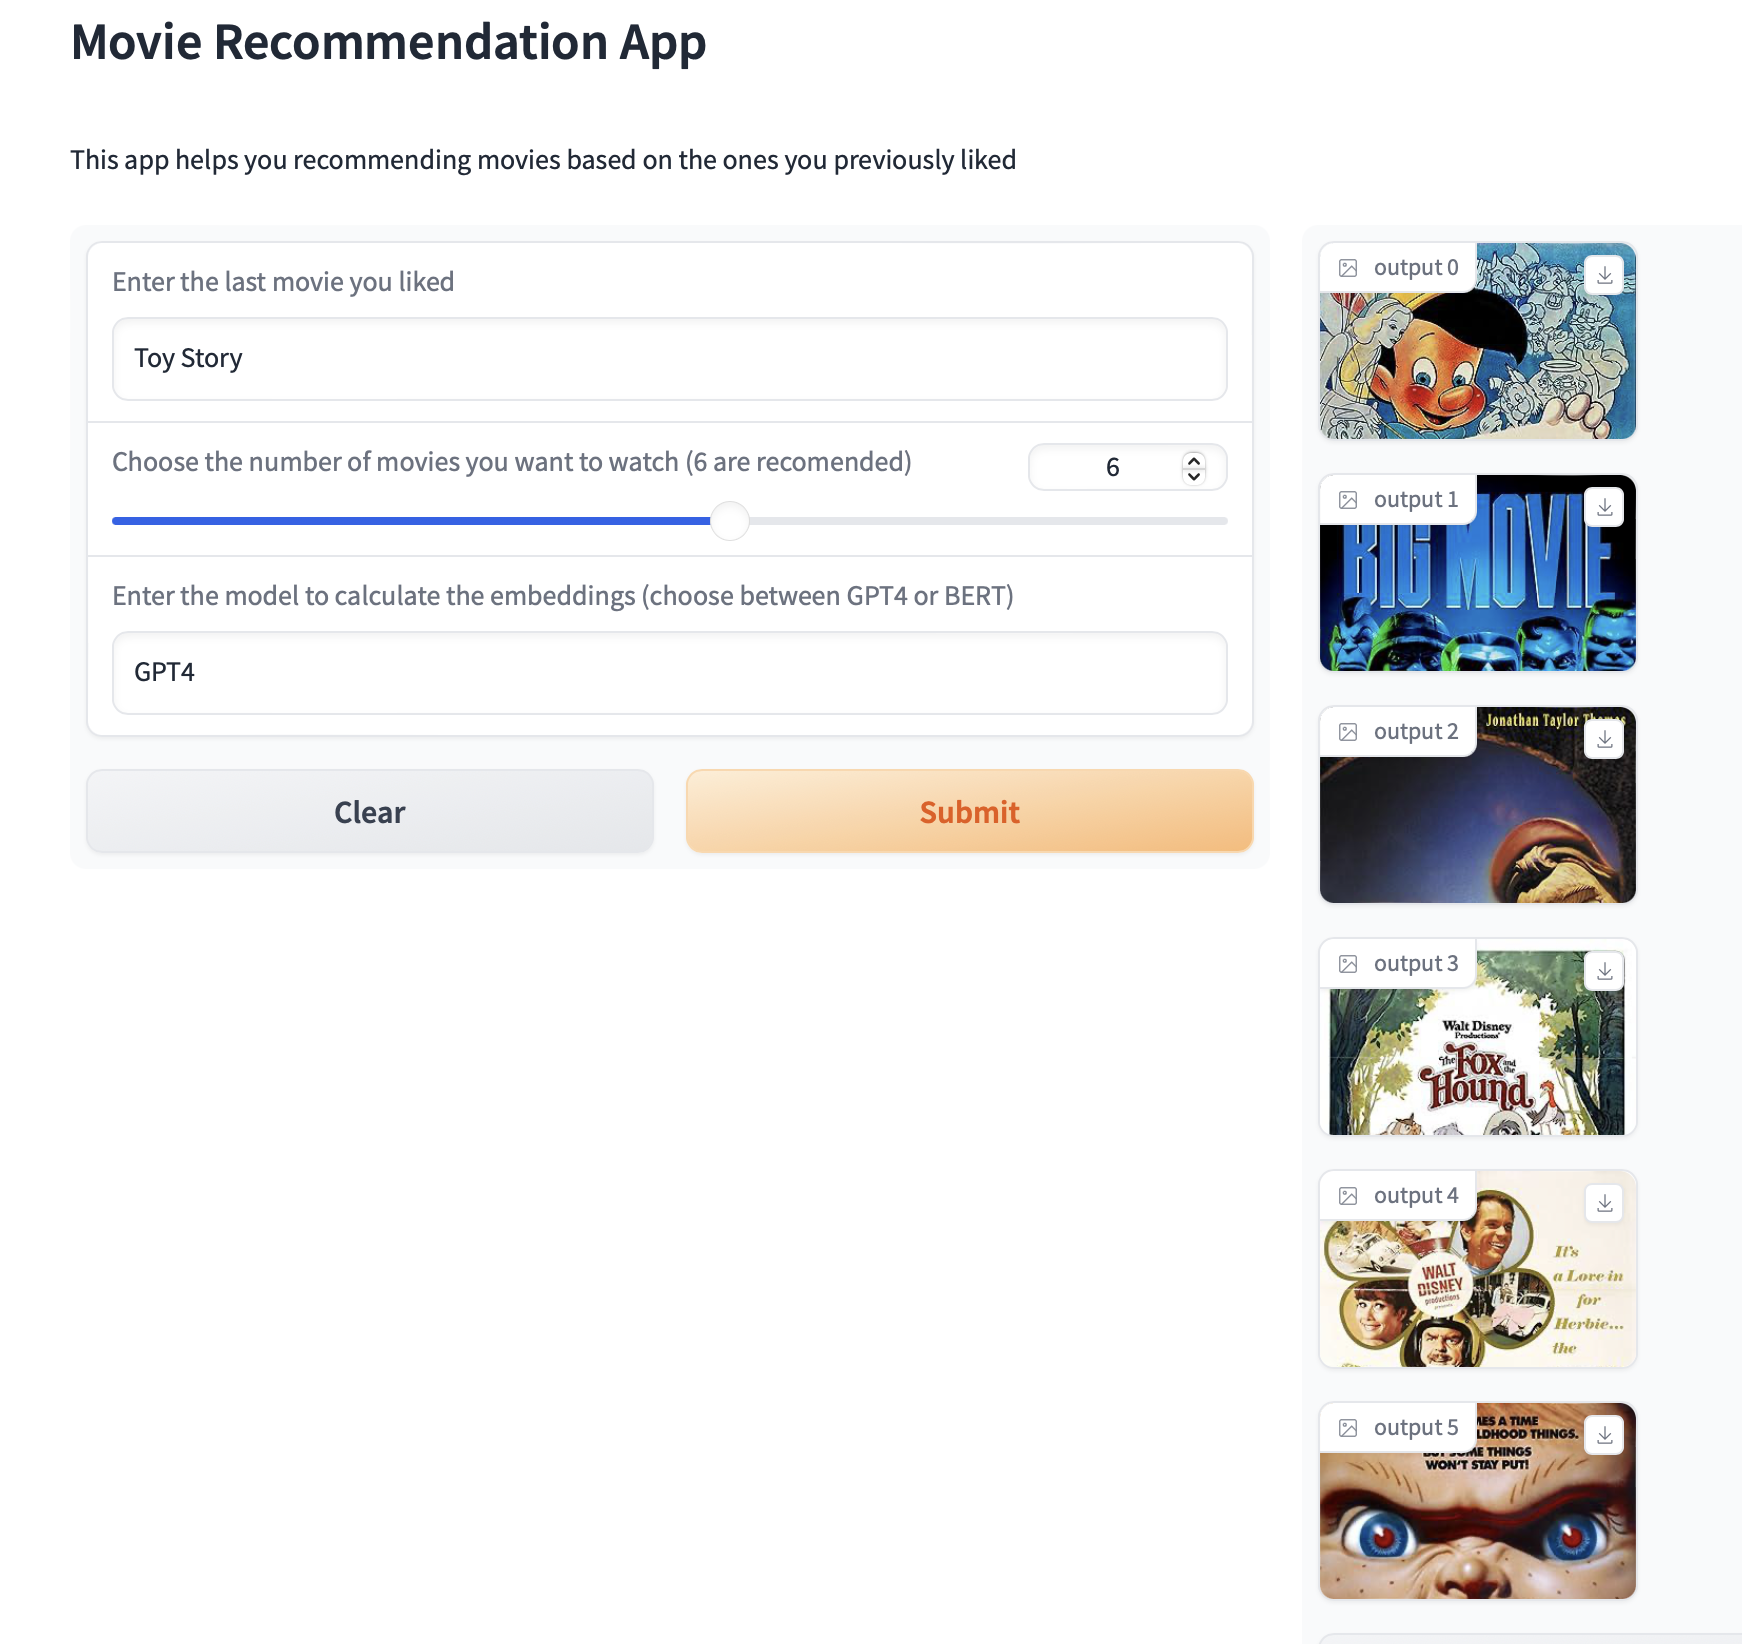

In [1]:
from IPython import display
display.Image("Screenshot 2024-02-05 at 17.25.34.png")

Cargo el dataset de peliculas:

In [1]:
# Columna de overviews
import pandas as pd
df = pd.read_csv('movies_metadata.csv')
film_overviews = df['overview'].tolist()


/var/folders/yc/q9_6ht1x43s552t2rfm6pw1c0000gn/T/ipykernel_59834/930283255.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('movies_metadata.csv')


In [2]:
#Modelo BERT
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
model = SentenceTransformer('bert-base-nli-mean-tokens')

def calculate_similarity(input_sentence, document_embeddings):
    input_embedding = model.encode([input_sentence])
    scores = cosine_similarity(input_embedding, document_embeddings)[0]
    return scores

/Users/gustavo.aguado/anaconda3/envs/base_ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Modelo GPT
from astrapy.db import AstraDB
import langchain
from langchain_openai import OpenAIEmbeddings
import json
import os

from astrapy.db import AstraDB
from dotenv import load_dotenv
# Initialize the client
load_dotenv()
db = AstraDB(
    token=os.getenv("ASTRA_DB_APPLICATION_TOKEN"),
    api_endpoint=os.getenv("ASTRA_DB_API_ENDPOINT"),
)


secret_string = os.getenv("OPENAI_API_KEY")

# Configurar el motor de OpenAI
engine = "gpt-4"
embeddings = OpenAIEmbeddings(api_key=secret_string, model="text-embedding-3-large")

def get_embedding(text):
    query_result = embeddings.embed_query(text)
    print(query_result)
    return query_result

def get_similarity(movie_description,N):
    db = AstraDB(token=os.getenv("ASTRA_DB_APPLICATION_TOKEN"), api_endpoint=os.getenv("ASTRA_DB_API_ENDPOINT"))
    collection = db.collection(collection_name="vector_movies")
    vector_embedding = get_embedding(movie_description)
    list_vec = collection.vector_find(
        vector=vector_embedding,
        limit=10
    )

    # Extract the movie titles from the 'text' values in the list
    titles = [item['text'].split(':')[0].strip('\"') for item in list_vec]

    return titles[1:(N+1)]

result = get_similarity('Toy Story',6)
print(result)

[-0.03298373886492768, 0.03965032465500274, 0.0018729937692091802, 0.01631726880180457, 0.02919013233770049, -0.011483991496296945, 0.027602849474545908, 0.016253776816726136, 0.03361865126513145, 0.032729774649904224, 0.003245993511030473, -0.011547482550052807, -0.01947596106618284, 0.013142702144172836, 0.031174234985321143, 0.031380582539842196, -0.026523496904083375, 0.04225347182883171, -0.00958718823268335, -0.069776952131078, 0.02817427175231639, -0.013428413283058079, 0.010349084603043996, 0.004797562481824399, -0.0007127892444957974, 0.002200370883017877, -0.0025297321795679354, -0.00843640880882208, -0.029825044737904264, 0.007984032838920447, -0.0029344891606607423, 0.0138093614682384, -0.004138840354385568, 0.016182348100682253, 0.0006845157463769454, 0.018952157311559897, -0.0030892493608902483, -0.006523732548938878, -0.015118869923473189, 0.04311060152019715, 0.000945425357694754, -0.04047571487308697, 0.007245946195794858, 0.009047512878774658, 0.01717440035581515, 0.0

# App de recomendadión de Peliculas:

In [24]:
import gradio as gr
import random
import requests
from dotenv import load_dotenv
import matplotlib
import os
from PIL import Image, ImageTk
import tkinter as tk
import io

# Cargar variables de entorno desde .env
load_dotenv()

url_omdb = "http://www.omdbapi.com/?apikey=" + os.getenv("OMDB_API_KEY") + "&t="

df_subset = df.head(1000)
# Drop rows with null values in the 'overview' column
df_subset = df_subset.dropna(subset=['overview']).reset_index(drop=True)

# Drop NA values from the DataFrame
#df_subset = df_subset.dropna()

# Gradio function to calculate similarity and return top 5 similar films
def find_similar_films(film_name, N, embedding):
    # Get the overview of the specified film
    overview = df_subset[df_subset['original_title'] == film_name]['overview'].values
    if len(overview) == 0 or pd.isna(overview[0]) or not isinstance(overview[0], str):
        return "Film overview not available or invalid."

    overview = overview[0]
    # Calculate similarity scores
    if embedding == 'BERT':
        film_overview_embeddings = model.encode(df_subset['overview'])
        similarity_scores = calculate_similarity(overview, film_overview_embeddings)
        # Create a dataframe with film titles and their similarity scores
        result_df = pd.DataFrame({'Film': df_subset['original_title'], 'Similarity Score': similarity_scores})
        result_df = result_df[result_df['Film'] != film_name]
        # Sort the dataframe by similarity scores in descending order
        result_df = result_df.sort_values(by='Similarity Score', ascending=False)
        top_N_films = result_df.head(N)
        films_info = []
        for idx, row in top_N_films.iterrows():
            film_title = row['Film']
            try:
                film_poster = get_poster(film_title)
            except Exception as e:
                return {"Error": str(e)}

            try:
                image_content = requests.get(film_poster).content
            except Exception as e:
                return {"Error": str(e)}

            try:
                image = Image.open(io.BytesIO(image_content))
            except Exception as e:
                return {"Error": str(e)}

            films_info.append({"Title": film_title, "Poster": image})

            # Now, access 'Poster' from each dictionary in the list
        posters = [item['Poster'] for item in films_info]

# You can use 'posters' as needed
    
    elif embedding == 'GPT4':
        top_N_films = get_similarity(film_name,N)
        films_info = []
        for idx in top_N_films:
            film_title = idx
            try:
                film_poster = get_poster(film_title)
            except Exception as e:
                return {"Error": str(e)}

            try:
                image_content = requests.get(film_poster).content
            except Exception as e:
                return {"Error": str(e)}

            try:
                image = Image.open(io.BytesIO(image_content))
            except Exception as e:
                return {"Error": str(e)}

            films_info.append({"Title": film_title, "Poster": image})

            # Now, access 'Poster' from each dictionary in the list
        posters = [item['Poster'] for item in films_info]

    return posters


def get_poster(movie):
    """ 
    Devuelve la ruta al poster en jpg
    
    Args:
        movie (str): El título de la película
    """
    movie = movie.lower().replace(" ", "+")
    result = requests.get(url_omdb + movie)
    result_json = result.json()
    return result_json['Poster']

input_text1 = gr.Textbox(label="Enter the last movie you liked")
input_text2 = gr.Textbox(label="Enter the model to calculate the embeddings (choose between GPT4 or BERT)")
input_text3 = gr.Slider(value=2, minimum=1, maximum=10, label="Choose the number of movies you want to watch (6 are recomended)")
output_posters = gr.Image(height=100, width=50)
output_posters2 = gr.Image(height=100, width=50)
output_posters3 = gr.Image(height=100, width=50)
output_posters4 = gr.Image(height=100, width=50)
output_posters5 = gr.Image(height=100, width=50)
output_posters6 = gr.Image(height=100, width=50)

# Create Gradio Interface for finding similar films
find_similar_films_interface = gr.Interface(fn=find_similar_films, inputs=[input_text1, input_text3,input_text2], outputs=[output_posters,output_posters2,output_posters3,output_posters4,output_posters5,output_posters6] , title='Movie Recommendation App ', description='This app helps you recommending movies based \
                                            on the ones you previously liked')

# Launch the interface
find_similar_films_interface.launch()








Running on local URL:  http://127.0.0.1:7873

To create a public link, set `share=True` in `launch()`.


[-0.03298373886492768, 0.03965032465500274, 0.0018729937692091802, 0.01631726880180457, 0.02919013233770049, -0.011483991496296945, 0.027602849474545908, 0.016253776816726136, 0.03361865126513145, 0.032729774649904224, 0.003245993511030473, -0.011547482550052807, -0.01947596106618284, 0.013142702144172836, 0.031174234985321143, 0.031380582539842196, -0.026523496904083375, 0.04225347182883171, -0.00958718823268335, -0.069776952131078, 0.02817427175231639, -0.013428413283058079, 0.010349084603043996, 0.004797562481824399, -0.0007127892444957974, 0.002200370883017877, -0.0025297321795679354, -0.00843640880882208, -0.029825044737904264, 0.007984032838920447, -0.0029344891606607423, 0.0138093614682384, -0.004138840354385568, 0.016182348100682253, 0.0006845157463769454, 0.018952157311559897, -0.0030892493608902483, -0.006523732548938878, -0.015118869923473189, 0.04311060152019715, 0.000945425357694754, -0.04047571487308697, 0.007245946195794858, 0.009047512878774658, 0.01717440035581515, 0.0

In [16]:
find_similar_films('Toy Story',6,'GPT')

[-0.032949416512470235, 0.03971071010049974, 0.0018827669966901082, 0.01636360706545984, 0.0291243630927093, -0.01151483646202066, 0.027600689619219767, 0.016268377473366746, 0.03367951005185064, 0.032758957328284044, 0.0032596272510469135, -0.011554515458726116, -0.019442695347158194, 0.013149610194962934, 0.031140054262701417, 0.031314639985560354, -0.02655316596884079, 0.04225016588964896, -0.00955469588741618, -0.06977149565281274, 0.02823555356650707, -0.013419427372560038, 0.0103244674921795, 0.0047813158433786355, -0.0006849582149666754, 0.002206150587008945, -0.0025077107291397805, -0.00846749137768667, -0.029838585033407517, 0.00799928014788482, -0.0029203720620458945, 0.013800344809609883, -0.004138516562411508, 0.016141404683909285, 0.0006403193436730367, 0.01893480418932835, -0.0030612325003502652, -0.0064835434050589166, -0.015165301364955051, 0.04313897541585118, 0.0009245199829528936, -0.0404725468372445, 0.0072453796761424135, 0.009086483726291792, 0.017204799932970444,

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x458>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x450>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x400>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x459>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x447>]